Reading C:\Users\dhanu\Desktop\Caps\code\combined-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5996.00 ms
        0 CTF compensation matrices available
Not setting metadata
1050 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 6 - 64 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 6.00, 64.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 3 channels (please be patient, this may take a while)


C:\Users\dhanu\AppData\Local\Temp\ipykernel_3672\2639857521.py:21: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 3 components
Fitting ICA took 1.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (3 components)
    Zeroing out 0 ICA components
    Projecting back using 3 PCA components


C:\Users\dhanu\AppData\Local\Temp\ipykernel_3672\2639857521.py:22: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


the accuracy for the FBCCA on the EEG data is 0.8980952380952381


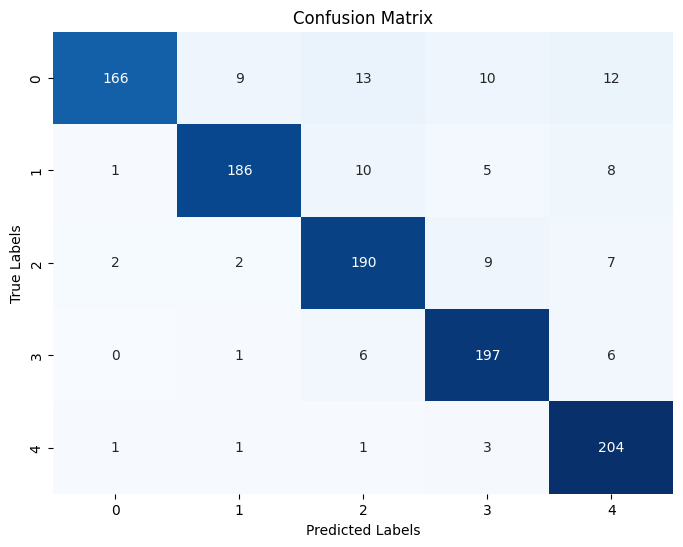

In [1]:
import numpy as np
from scipy.signal import butter, lfilter
from sklearn.decomposition import FastICA
from sklearn.cross_decomposition import CCA
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the epochs
epochs = mne.read_epochs("combined-epo.fif")

# Apply preprocessing filter
epochs.filter(6, 64, method='iir', iir_params=dict(order=5, ftype='butter'))

# Define ICA parameters and fit ICA
n_components = 3
method = 'fastica'
ica = ICA(n_components=n_components, method=method, random_state=97)
ica.fit(epochs)
ica.apply(epochs)

def generate_reference_signals(frequencies, sfreq, n_samples):
    t = np.arange(n_samples) / sfreq
    ref_signals = []
    for freq in frequencies:
        ref_signals.append(np.sin(2 * np.pi * freq * t))
        ref_signals.append(np.cos(2 * np.pi * freq * t))
    return np.array(ref_signals).T

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

def fbcca(epochs, frequencies, sfreq, n_samples, filter_bank):
    cca = CCA(n_components=1)
    n_epochs = epochs.shape[0]
    n_channels = epochs.shape[1]
    
    fbcca_results = []

    for epoch_idx in range(n_epochs):
        epoch_data = epochs[epoch_idx]

        max_corr = 0
        detected_freq = None

        for freq in frequencies:
            corr_sum = 0

            for fb in filter_bank:
                filtered_data = np.zeros((n_channels, n_samples))
                
                for ch in range(n_channels):
                    filtered_data[ch, :] = bandpass_filter(epoch_data[ch, :], fb['low'], fb['high'], sfreq)
                
                filtered_data = filtered_data.T
                ref_signals = generate_reference_signals([freq], sfreq, n_samples)
                
                X_c, Y_c = cca.fit_transform(filtered_data, ref_signals)
                
                corr = np.corrcoef(X_c.T, Y_c.T)[0, 1]
                corr_sum += corr
            
            avg_corr = corr_sum / len(filter_bank)

            if avg_corr > max_corr:
                max_corr = avg_corr
                detected_freq = freq
        
        fbcca_results.append(detected_freq)

    return fbcca_results

frequencies = [8, 9, 10, 11, 12]  # Example stimulus frequencies in Hz
sfreq = 250
n_samples_per_epoch = 1500
# Create the filter bank
filter_bank = [
    {'low': 6, 'high': 18},
    {'low': 14, 'high': 36},
    {'low': 28, 'high': 64}
]

# Get the data from epochs (n_epochs, n_channels, n_times)
epochs_data = epochs.get_data(copy=False)

# Apply FBCCA
fbcca_results = fbcca(epochs_data, frequencies, sfreq, n_samples_per_epoch, filter_bank)

# Evaluate results
labels = epochs.events[:, -1] + 7
test_accuracy = accuracy_score(labels, fbcca_results)
print(f"the accuracy for the FBCCA on the EEG data is {test_accuracy}")

cm = confusion_matrix(labels, fbcca_results)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
